In [4]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve 
from lightkurve import KeplerLightCurve, KeplerTargetPixelFile
from k2sc.standalone import k2sc_lc
import k2sc
from astropy.table import Table
from astropy.io import fits

import halophot

import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [45]:
!halo ktwo212573842-c06_lpd-targ.fits.gz  --data-dir ../data/ --save-dir . --name Spica -c 6 --thresh 0.5 --minflux -100 --rr [0,17.5] --do-plot

Data loaded!
Getting annulus from 0.0 to 17.5
Using 416 pixels
Not splitting
Taking cadences from beginning to end
335 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
Time taken: 0.615224 s
Total variation per point (first order): 0.000696 
Total variation per point (second order): 0.000498
Saved halo-corrected light curve to ./Spica_halo_lc_o1.fits
Everything saved to ./Spica_all_o1_sub1.png


In [46]:
f = fitsio.FITS('./Spica_halo_lc_o1.fits')
hdr = fitsio.read_header('./Spica_halo_lc_o1.fits')


In [47]:
def match_cadences(halocads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in halocads])
    return np.where(indices==1)[0]



In [48]:
tpf = lightkurve.open('../data/ktwo212573842-c06_lpd-targ.fits.gz')
lc = tpf.to_lightcurve('aperture')
lc.pos_corr1 = tpf.pos_corr1
lc.pos_corr2 = tpf.pos_corr2
lc.primary_header = tpf.hdu[0].header
lc.data_header = tpf.hdu[1].header

inds_lc = match_cadences(lc.cadenceno,f[1]['cadence'][:])
lc = lc[inds_lc]
lc.pos_corr1 = lc.pos_corr1[inds_lc]
lc.pos_corr2 = lc.pos_corr2[inds_lc]


inds_flux = match_cadences(f[1]['cadence'][:],lc.cadenceno)
lc.flux = f[1]['corr_flux'][inds_flux]

In [49]:
# now the magic happens
lc.__class__ = k2sc_lc
lc.campaign = 6

In [50]:
lc.k2sc()

Using default splits [2390, 2428] for campaign 6
Starting initial outlier detection
  Flagged 289 ( 8.1%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =    2.01 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 1 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 2 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 3 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 4 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 5 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 6 -3973.898941757509
  DE iteration %3i -ln(L) %4.1f 7 -3988.985566268027
  DE iteration %3i -ln(L) %4.1f 8 -3991.4286201596037
  DE iteration %3i -ln(L) %4.1f 9 -4026.2168781958376
  DE iteration %3i -ln(L) %4.1f 10 -4026.2168781958376
  DE iteration %3i -ln(L) %4.1f 11 -4026.2168781958376
  DE iteration %3i -ln(L) %4.1f 

In [51]:
to_save = ['time', 'flux', 'flux_err','centroid_col', 'centroid_row', 'quality', 'cadenceno','pos_corr1', 'pos_corr2','tr_position', 'tr_time','corr_flux']

dummy = fits.getheader('../data/ktwo212573842-c06_lpd-targ.fits.gz')
dummy['NAXIS']=1
dummy['halo'] =(halophot.__version__,'halophot version')
dummy['order']=(1,'halophot TV order')
dummy['sub']=(1,'halophot subsampling')
dummy['starname']=('Spica','Star Identifier')

hdu = fits.PrimaryHDU(f[0][:,:],dummy) # can't save a masked array yet so just using pixelmap
cols = [fits.Column(name=key,format="D",array=lc.__dict__[key]) for key in to_save]
tab = fits.BinTableHDU.from_columns(cols)


hdul = fits.HDUList([hdu, tab])
hdul.writeto('spica_c6_halo_k2sc.fits',overwrite=True)


In [52]:
from halophot.halo_tools import *

def plot_k2sc(lc,image,weightmap,save_file=None,formal_name='test'):
    min_p,max_p=1./24.,20.

    PW,PH = 8.27, 11.69
    
    frequency, power, spower = get_pgram(lc.time,lc.corr_flux-lc.tr_time,min_p=min_p,max_p=max_p)
    
    rc('axes', labelsize=7, titlesize=8)
    rc('font', size=6)
    rc('xtick', labelsize=7)
    rc('ytick', labelsize=7)
    rc('lines', linewidth=1)
    fig = plt.figure(figsize=(PW,PH))
    gs1 = GridSpec(3,2)
    gs1.update(top=0.95, bottom = 2/3.*1.05,hspace=0.0,left=0.09,right=0.96)
    gs2 = GridSpec(1,2)
    gs2.update(top=2/3.*0.97,bottom=1/3.*1.07,hspace=0.35,left=0.09,right=0.96)
    gs3 = GridSpec(2,2)
    gs3.update(top=1/3.*0.96,bottom=0.04,hspace=0.07,left=0.09,right=0.96)

    ax_lctime = subplot(gs1[0,:])
    ax_lcpos = subplot(gs1[1,:],sharex=ax_lctime)
    ax_lcwhite = subplot(gs1[2,:],sharex=ax_lctime)
    ax_fluxmap = subplot(gs2[0,0])
    ax_weightmap = subplot(gs2[0,1])
    ax_periodogram   = subplot(gs3[0,:])
    ax_logpgram    = subplot(gs3[1,:])

    plot_lc(ax_lctime,lc.time,lc.flux-lc.tr_time+np.nanmedian(lc.tr_time),formal_name,trend=lc.tr_position)
    plot_lc(ax_lcpos,lc.time,lc.flux-lc.tr_position+np.nanmedian(lc.tr_position),formal_name,trend=lc.tr_time)
    plot_lc(ax_lcwhite,lc.time,lc.corr_flux-lc.tr_time,formal_name+': Whitened')
    plot_weightmap(ax_weightmap,weightmap,formal_name)
    plot_fluxmap(ax_fluxmap,image,formal_name)
    plot_pgram(ax_periodogram,frequency,power,spower,formal_name)        
    plot_log_pgram(ax_logpgram,frequency,power,spower,formal_name)  

    fig.suptitle(formal_name+' Detrended',y=0.99,fontsize=20)
    ax_periodogram.set_title('Periodograms')
    ax_fluxmap.set_title('Flux Map')
    ax_weightmap.set_title('TV-Min Weight Map')

    if save_file is not None:
        plt.savefig(save_file)
        
def plot_lc(ax1,time,lc,name,trend=None,title=False):
        m = (lc>0.) * (np.isfinite(lc))

        ax1.plot(time[m],lc[m]/np.nanmedian(lc[m]),'.')
        dt = np.nanmedian(time[m][1:]-time[m][:-1])
        ax1.set_xlim(time[m].min()-dt,time[m].max()+dt)
        if trend is not None:
            ax1.plot(time[m],trend[m]/np.nanmedian(trend[m]),'-',color=colours[2])
            plt.legend(labels=['Flux','Trend'])
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Relative Flux')
        if title:
            plt.title(r'%s' % name)

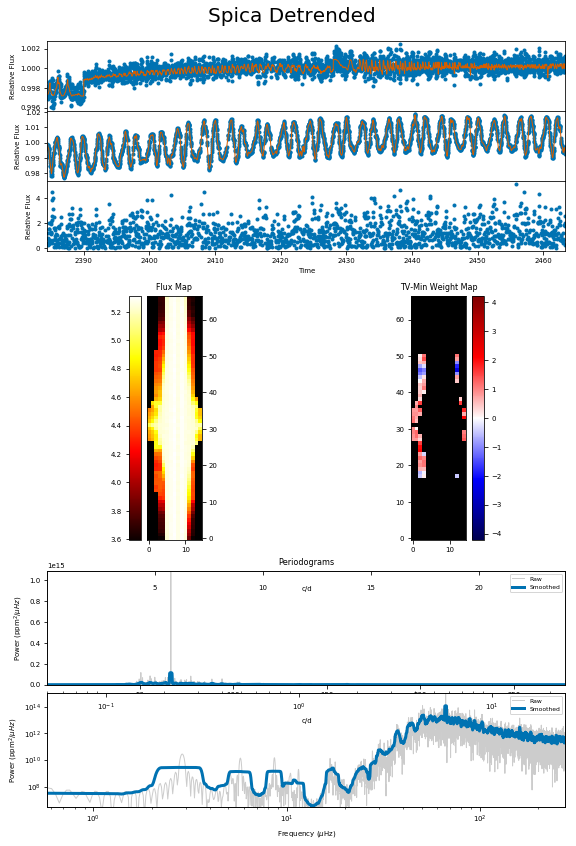

In [53]:
plot_k2sc(lc,np.nanmean(tpf.flux,axis=0),f[0][:,:].T,formal_name='Spica',save_file='spica_plots.png')